In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# import data

In [2]:
data = pd.read_csv('./train.csv',nrows=5000000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# preprocessing

In [3]:
#drop minus fare--------------------------------------------------------------------------------------------------------------------
data.drop(data.index[data.fare_amount <= 0], inplace=True)

#drop dulplicate column---------------------------------------------------------------------------------------------------------------
data.drop('key',axis=1,inplace=True)

#drop nan---------------------------------------------------------------------------------------------------------------------------
data.dropna()

#correct wrong location---------------------------------------------------------------------------------------------------------------
wrong_data = data[data.pickup_longitude > 0]
data = data[data.pickup_longitude < 0]
corrected = wrong_data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
corrected.columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
for i in corrected.columns:
    wrong_data[i] = corrected[i]
data = pd.concat([data,wrong_data],axis=0)

#add distance column---------------------------------------------------------------------------------------------------------------
data['distance'] = np.sqrt((data['pickup_longitude']-data['dropoff_longitude'])**2 + (data['pickup_latitude']-data['dropoff_latitude'])**2)

#drop distance = 0---------------------------------------------------------------------------------------------------------------
data = data[data['distance'] != 0]

#drop illogical fare---------------------------------------------------------------------------------------------------------------
data = data[data['fare_amount'] < 50]

#convert to time stamp---------------------------------------------------------------------------------------------------------------
data['time'] = pd.to_datetime(data['pickup_datetime'])

In [4]:
#extract features from time stamp(year,month,weekday,hour)
class time_extract:
    def __init__(self,time_type):
        self.time_type = time_type
    def trans(self,stamp):
        if self.time_type == 'y':
            return stamp.year
        elif self.time_type == 'm':
            return stamp.month
        elif self.time_type == 'd':
            return stamp.day
        elif self.time_type == 'w':
            return stamp.weekday_name
        elif self.time_type == 'h':
            return stamp.hour
#---------------------------------------------------------------------------------------------------------------------------        
dict_weekday = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
data['year']=data['time'].apply(time_extract('y').trans)
data['month']=data['time'].apply(time_extract('m').trans)
data['day']=data['time'].apply(time_extract('d').trans)
data['weekday']=data['time'].apply(time_extract('w').trans)
data['weekday']=data['weekday'].map(dict_weekday)
data['hour']=data['time'].apply(time_extract('h').trans)

data = data.drop(['pickup_datetime','time'],axis=1)

In [5]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,day,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009,6,15,1,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2010,1,5,2,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,2011,8,18,4,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,2012,4,21,6,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,2010,3,9,2,7


# plot data

image location range: -74.3, -73.7, 40.5, 40.9

In [6]:
#load image
ny_img = cv2.imread('./nyc.png')
ny_img = cv2.flip(ny_img,0)
ny_img = cv2.cvtColor(ny_img,cv2.COLOR_BGR2RGB)
ny_img.shape

(1538, 1752, 3)

In [7]:
#transfer scale of data to plot in image
data['x1']=(data['pickup_longitude']+74.3)*(1752/0.6)
data['y1']=(data['pickup_latitude']-40.5)*(1538/0.4)
data['x2']=(data['dropoff_longitude']+74.3)*(1752/0.6)
data['y2']=(data['dropoff_latitude']-40.5)*(1538/0.4)

In [153]:
#plot image
def plot_ny(x1,y1,x2,y2):
    #plot image
    xtick = np.round(np.linspace(0,1752,10)/1752*0.6-74.3,2)
    ytick = np.round(np.linspace(0,1538,10)/1538*0.4+40.5,2)
    plt.figure(figsize=(16,16))
    axe = plt.gca()
    axe.invert_yaxis()
    #-----------------------pickup-----------------------
    plt.subplot(1,2,1)
    plt.imshow(ny_img)
    plt.title('pickup')
    plt.xlim(0,1752);plt.ylim(0,1538)
    plt.xticks(np.linspace(0,1752,10),xtick);plt.yticks(np.linspace(0,1538,10),ytick)
    plt.grid()
    plt.scatter(x1,y1,color='r',s=1)
    #-----------------------dropoff-----------------------
    plt.subplot(1,2,2)
    plt.imshow(ny_img)
    plt.title('dropoff')
    plt.xlim(0,1752);plt.ylim(0,1538)
    plt.xticks(np.linspace(0,1752,10),xtick);plt.yticks(np.linspace(0,1538,10),ytick)
    plt.grid()
    plt.scatter(x2,y2,color='r',s=1)

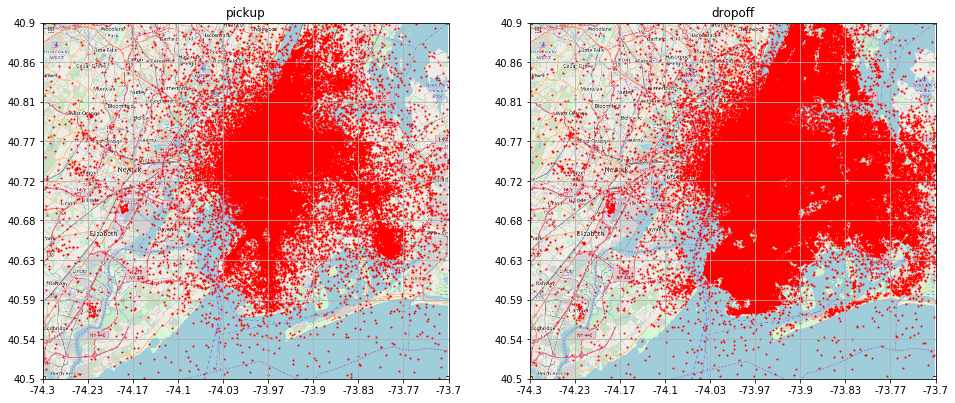

In [8]:
#plot image
plot_ny(data.x1,data.y1,data.x2,data.y2)

# 画像処理

# (1) remove points located on the sea

In [9]:
#turn bgr to hsv to extract sea
ny_img_test = ny_img.copy()
#bgr to hsv
HSV = cv2.cvtColor(ny_img_test, cv2.COLOR_RGB2HSV)
#create mask
LowerBlue = np.array([95, 50, 50])
UpperBlue = np.array([130, 255, 255])
mask = cv2.inRange(HSV, LowerBlue, UpperBlue)
#masking
sea = cv2.bitwise_and(ny_img_test,ny_img_test, mask=mask)
#to gray
sea = cv2.cvtColor(sea,cv2.COLOR_BGR2GRAY)
#threshold
_ , sea = cv2.threshold(sea,120,255,0)

In [144]:
#transfer sea area to location
sea_loc = pd.DataFrame([])
sea_loc['value'] = sea.reshape(1,-1)[0]
sea_loc['number'] = range(len(sea_loc))
sea_loc['x'] = (sea_loc['number'] % 1752).astype('int32')
sea_loc['y'] = np.round(sea_loc['number'] / 1752,0).astype('int32')
sea_loc = sea_loc[sea_loc['value'] == 255]
sea_loc['xy'] = sea_loc['x']*10000 + sea_loc['y']

In [149]:
#mapping
#turn loacation type to int
data.dropna(inplace=True)
data['x1'] = np.round(data['x1'],0).astype('int32')
data['y1'] = np.round(data['y1'],0).astype('int32')
data['x2'] = np.round(data['x2'],0).astype('int32')
data['y2'] = np.round(data['y2'],0).astype('int32')
#searching
data['xy1'] = data['x1'] * 10000 + data['y1']
data['xy2'] = data['x2'] * 10000 + data['y2']
data['filt1'] = np.isin(data['xy1'],sea_loc['xy'])
data['filt2'] = np.isin(data['xy2'],sea_loc['xy'])
#filtering
data = data.loc[(data['filt1'] == 0) & (data['filt2'] == 0)]

In [151]:
#remove points outside New York
data.drop(['xy1','xy2','filt1','filt2'],axis=1,inplace=True)
data = data.loc[(data.x1 <= 1752) & (data.x1 >= 0) & (data.x2 <= 1752) & (data.x2 >= 0)]
data = data.loc[(data.y1 <= 1538) & (data.y1 >= 0) & (data.y2 <= 1538) & (data.y2 >= 0)]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


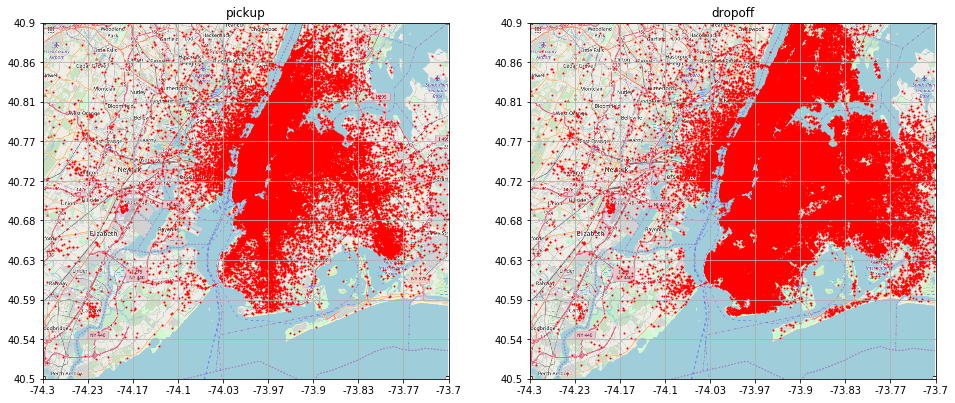

In [154]:
#plot points after filtered
plot_ny(data.x1,data.y1,data.x2,data.y2)

In [155]:
#save file
data.to_csv(r'C:\Users\User\Downloads\kaggle\python_homework\ny_filtered.csv')